# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.234165,True,8.570079
1,1.543155,False,3.829854
2,0.357019,True,6.281521
3,1.389560,True,6.493989
4,1.141525,True,12.246060
...,...,...,...
995,0.725644,True,7.631750
996,2.076285,False,5.775634
997,-0.053524,False,-1.155152
998,-1.066127,True,2.538604


<AxesSubplot:xlabel='v0'>

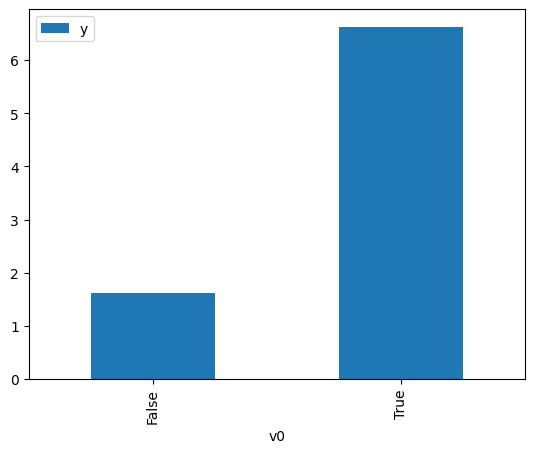

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

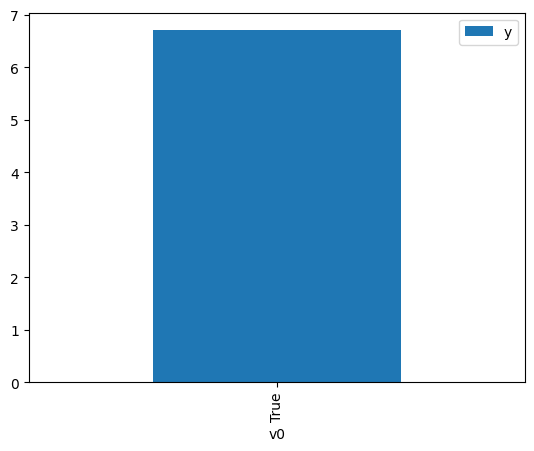

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.597058,False,2.073183,0.421137,2.374526
1,0.867042,False,4.049314,0.389956,2.564389
2,-0.381352,False,0.188733,0.537624,1.860035
3,0.130813,False,-1.552430,0.476351,2.099293
4,0.505804,False,1.346932,0.431833,2.315710
...,...,...,...,...,...
995,1.022886,False,4.451887,0.372342,2.685701
996,0.852164,False,1.303248,0.391654,2.553274
997,0.997233,False,2.743467,0.375220,2.665104
998,0.384350,False,0.701378,0.446167,2.241315


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.488024,True,5.820279,0.566075,1.766550
1,0.888367,True,7.542445,0.612472,1.632728
2,1.220067,True,6.451814,0.649463,1.539735
3,0.421520,True,4.095262,0.558231,1.791374
4,0.194693,True,3.982480,0.531279,1.882249
...,...,...,...,...,...
995,0.973654,True,7.442966,0.622127,1.607388
996,0.074251,True,4.923468,0.516884,1.934671
997,-0.637360,True,5.034369,0.432055,2.314518
998,-0.705459,True,3.266786,0.424066,2.358125


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                          1.684e+04
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        17:34:48   Log-Likelihood:                         -1438.1
No. Observations:                1000   AIC:                                      2880.
Df Residuals:                     998   BIC:                                      2890.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4233      0.032     74.893      0.000       2.360       2.487
x2             5.0352      0.050     99.940      0.000       4.936       5.134
==============================================================================
Omnibus:                        1.139   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                1.006
Skew:                           0.059   Prob(JB):                        0.605
Kurtosis:                       3.101   Cond. No.                         2.16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""